In [1]:
import pandas as pd
import numpy as np

In [8]:
data = pd.read_csv('Data_csv.csv') 

data.head()

,Unnamed: 0,datetime,stock_code,exchange_code,product_type,expiry_date,right,trike_price,open,high,low,close,volume
0,1,19/04/22 13:59,NIFTY,NFO,Options,21-Apr-22,Put,"17,000.00",21.15,22.30,21.15,21.60,"2,70,000.00"
1,2,19/04/22 13:57,NIFTY,NFO,Options,21-Apr-22,Put,"17,000.00",20.70,21.25,20.45,21.00,"1,52,850.00"
2,3,19/04/22 13:58,NIFTY,NFO,Options,21-Apr-22,Put,"17,000.00",21.10,21.60,20.95,21.25,"1,42,250.00"
3,4,19/04/22 14:02,NIFTY,NFO,Options,21-Apr-22,Put,"17,000.00",18.85,19.25,17.30,17.35,"4,75,500.00"
4,5,19/04/22 14:01,NIFTY,NFO,Options,21-Apr-22,Put,"17,000.00",21.10,21.65,18.55,18.55,"4,46,350.00"


In [9]:
def filter_data_by_expiry(data, expiry_date):
    return data[data['expiry_date'] == expiry_date]

expiry_date = '21-Apr-22'
filtered_data = filter_data_by_expiry(data, expiry_date)
filtered_data.head()

,Unnamed: 0,datetime,stock_code,exchange_code,product_type,expiry_date,right,trike_price,open,high,low,close,volume
0,1,19/04/22 13:59,NIFTY,NFO,Options,21-Apr-22,Put,"17,000.00",21.15,22.30,21.15,21.60,"2,70,000.00"
1,2,19/04/22 13:57,NIFTY,NFO,Options,21-Apr-22,Put,"17,000.00",20.70,21.25,20.45,21.00,"1,52,850.00"
2,3,19/04/22 13:58,NIFTY,NFO,Options,21-Apr-22,Put,"17,000.00",21.10,21.60,20.95,21.25,"1,42,250.00"
3,4,19/04/22 14:02,NIFTY,NFO,Options,21-Apr-22,Put,"17,000.00",18.85,19.25,17.30,17.35,"4,75,500.00"
4,5,19/04/22 14:01,NIFTY,NFO,Options,21-Apr-22,Put,"17,000.00",21.10,21.65,18.55,18.55,"4,46,350.00"


In [10]:
print(data.columns)


Index(['Unnamed: 0', 'datetime', 'stock_code', 'exchange_code', 'product_type',
       'expiry_date', 'right', 'trike_price', 'open', 'high', 'low', 'close',
       'volume'],
      dtype='object')


In [14]:

def get_user_input():
    """Prompt the user for input parameters."""
    derivative = input("Choose derivative (Nifty, BankNifty, FinNifty, BankEx): ")
    expiry_date = input("Enter expiry date (YYYY-MM-DD): ")
    timeframe = input("Choose timeframe (1 minute, 5 minutes, 1 hour, 1 day): ")
    strategy = input("Choose strategy (Moving Average Crossover, RSI): ")
    return derivative, expiry_date, timeframe, strategy


derivative, expiry_date, timeframe, strategy = get_user_input()
print(f"Derivative: {derivative}, Expiry Date: {expiry_date}, Strategy: {strategy}")


Choose derivative (Nifty, BankNifty, FinNifty, BankEx): nifth
Enter expiry date (YYYY-MM-DD): 2022-04-21
Choose timeframe (1 minute, 5 minutes, 1 hour, 1 day): 1
Choose strategy (Moving Average Crossover, RSI): RSI
Derivative: nifth, Expiry Date: 2022-04-21, Strategy: RSI


In [18]:
def moving_average_crossover(data, short_window=50, long_window=200):
    data['short_mavg'] = data['close'].rolling(window=short_window).mean()
    data['long_mavg'] = data['close'].rolling(window=long_window).mean()
    
    data['signal'] = 0
    data.loc[short_window:, 'signal'] = np.where(data['short_mavg'][short_window:] > data['long_mavg'][short_window:], 1, 0)
    
    data['position'] = data['signal'].diff()
    
    return data


strategy_data = moving_average_crossover(filtered_data)
strategy_data[['close', 'short_mavg', 'long_mavg', 'signal', 'position']].tail()


,close,short_mavg,long_mavg,signal,position
21,20.95,NaN,NaN,0,0.0
22,20.35,NaN,NaN,0,0.0
23,21.10,NaN,NaN,0,0.0
24,21.25,NaN,NaN,0,0.0
25,21.15,NaN,NaN,0,0.0


In [19]:
def rsi_strategy(data, window=14):
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    data['signal'] = np.where(data['RSI'] < 30, 1, np.where(data['RSI'] > 70, -1, 0))

    return data

strategy_data = rsi_strategy(filtered_data)
strategy_data[['close', 'RSI', 'signal']].tail()

,close,RSI,signal
21,20.95,61.867704,0
22,20.35,61.389961,0
23,21.10,51.690821,0
24,21.25,52.380952,0
25,21.15,55.837563,0


<Axes: >

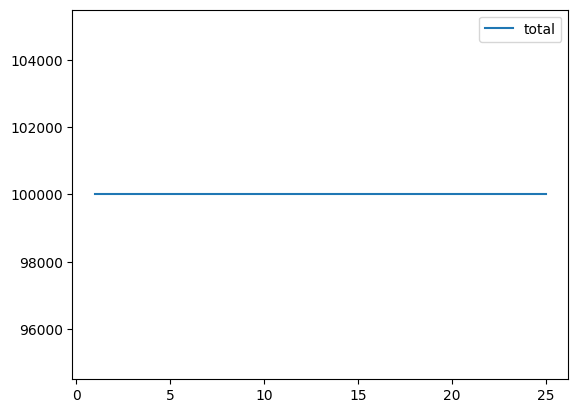

In [20]:

def backtest_strategy(data):
    initial_capital = 100000.0  # starting with 100,000 units of currency
    positions = pd.DataFrame(index=data.index).fillna(0.0)
    
    positions['position'] = data['signal']  
    
    portfolio = positions.multiply(data['close'], axis=0)
    pos_diff = positions.diff()

    portfolio['holdings'] = positions['position'].multiply(data['close'], axis=0)
    portfolio['cash'] = initial_capital - (pos_diff.multiply(data['close'], axis=0)).cumsum()
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    
    return portfolio

portfolio = backtest_strategy(strategy_data)
portfolio[['total']].plot()
